In [ ]:
from google.colab import drive

drive.mount("/drive")


Mounted at /drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad




In [ ]:
from tensorflow.keras import regularizers

In [ ]:
def read_data(path):
	
	#Lectura de archivos CSV
	train_data = pd.read_csv(path)                    #Archivo de Entrenamiento
	
	#Convierto Data a numpy arrays
	train_data = train_data.to_numpy()

	#Separo los datos en filenames y outputs
	#Filenames y Outputs del Conjunto de Entrenamiento
	train_filenames = train_data[:,0]
	train_outputs   = train_data[:,1]

	return train_filenames, train_outputs

train_filenames, train_outputs = read_data("/drive/MyDrive/TACC/Reto/train.csv")
sample_filenames, sample_outputs = read_data("/drive/MyDrive/TACC/Reto/sample_submission (4).csv")


In [ ]:
def resize(image, width, height):
	return cv2.resize(image,(width, height))

In [ ]:
def load_images(path,train_filenames):
    #Lista de Imagenes
    images = []

    for filename in train_filenames:
      img = cv2.imread(os.path.join(path,filename))
      if img is not None:
        img=resize (img,128,128)
        images.append(img)
    
    return images 

    '''for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path,filename))
        if img is not None:
            img=resize (img,128,128)
            images.append(img)
            fileNames.append(filename)'''
    #Se retorna lista de imagenes y sus nombres
    

In [ ]:
images = load_images('/drive/MyDrive/TACC/Reto/images',train_filenames)

In [ ]:
def rgb2gray(images):
    return [np.dot(image[...,:3], [0.299, 0.587, 0.144]) for image in images]
images = rgb2gray(images)

In [ ]:
images=np.asarray(images)

In [ ]:
images = images / 255.
mean = 0.5
std = 0.5
images = (images - mean) / std

In [ ]:
#ORDENAR ARREGLO DE FILENAMES
'''def file_name_outputs(train_filenames,train_outputs):
     return [x for (y,x) in sorted(zip(train_filenames,train_outputs), key=lambda pair: pair[0])]

train_outputs = file_name_outputs(train_filenames,train_outputs)'''

'def file_name_outputs(train_filenames,train_outputs):\n     return [x for (y,x) in sorted(zip(train_filenames,train_outputs), key=lambda pair: pair[0])]\n\ntrain_outputs = file_name_outputs(train_filenames,train_outputs)'

In [ ]:
train_outputs=np.asarray(train_outputs).astype(np.int)

In [ ]:
# Train validation split
x_train, x_val, y_train, y_val = train_test_split(images, train_outputs, test_size=0.3, random_state=42)

In [ ]:
x_train.shape

(2151, 128, 128)

In [ ]:
#AGREGO CANAL DE DATOS (COLOR)
x_train = x_train.reshape((-1, 128, 128, 1))
x_val = x_val.reshape((-1, 128, 128, 1))

In [ ]:
type(y_train),type(x_train)

(numpy.ndarray, numpy.ndarray)

In [ ]:
import tensorflow as tf
#Batch size
bs = 64

dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset_train = dataset_train.shuffle(buffer_size=100).batch(bs).prefetch(50)
dataset_test = tf.data.Dataset.from_tensor_slices((x_val, y_val))
dataset_test = dataset_test.batch(bs).prefetch(50)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, ReLU, Flatten, Dense 
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

def create_model():
    K.clear_session()
    
    input_layer = Input(shape=(128, 128, 1))
    convolutional_1 = Conv2D(32, kernel_size=3, padding="same")(input_layer)
    relu_1 = ReLU()(convolutional_1)
    max_pooling_1 = MaxPool2D(2)(relu_1)
    
    convolutional_2 = Conv2D(64, kernel_size=3, padding="same")(max_pooling_1)
    relu_2 = ReLU()(convolutional_2)
    max_pooling_2 = MaxPool2D(2)(relu_2)

    convolutional_3 = Conv2D(128, kernel_size=3, padding="same")(max_pooling_2)
    relu_3 = ReLU()(convolutional_3)
    max_pooling_3 = MaxPool2D(2)(relu_3)
    
    convolutional_4 = Conv2D(256, kernel_size=3)(max_pooling_3)
    relu_4 = ReLU(256)(convolutional_4)
    
    flatten = Flatten()(relu_4)
    
    dense1 = Dense(256, activation="tanh",kernel_initializer='glorot_normal')(flatten)
    drop1=Dropout(0.2)(dense1)
    dense2 = Dense(128, activation="tanh",kernel_initializer='glorot_normal')(drop1)
    drop2=Dropout(0.1)(dense2)
    dense3 = Dense(64, activation="tanh",kernel_initializer='glorot_normal')(drop2)
    drop3=Dropout(0.1)(dense3)
    output_layer = Dense(1, activation="sigmoid")(drop3)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

In [ ]:
lr = 0.0001
momentum = 0.9

model = create_model()

model.compile(optimizer=Adam(lr), loss='MSE', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
re_lu (ReLU)                 (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0     

In [ ]:
history = model.fit(dataset_train, batch_size=64, epochs=16, validation_data=dataset_test)

Epoch 1/16
34/34 [==============================] - 2s 55ms/step - loss: 0.1809 - accuracy: 0.7204 - val_loss: 0.0576 - val_accuracy: 0.9144
Epoch 2/16
34/34 [==============================] - 2s 48ms/step - loss: 0.0571 - accuracy: 0.9287 - val_loss: 0.0469 - val_accuracy: 0.9382
Epoch 3/16
34/34 [==============================] - 2s 48ms/step - loss: 0.0444 - accuracy: 0.9444 - val_loss: 0.0419 - val_accuracy: 0.9458
Epoch 4/16
34/34 [==============================] - 2s 48ms/step - loss: 0.0364 - accuracy: 0.9557 - val_loss: 0.0417 - val_accuracy: 0.9469
Epoch 5/16
34/34 [==============================] - 2s 49ms/step - loss: 0.0315 - accuracy: 0.9576 - val_loss: 0.0388 - val_accuracy: 0.9523
Epoch 6/16
34/34 [==============================] - 2s 48ms/step - loss: 0.0262 - accuracy: 0.9708 - val_loss: 0.0379 - val_accuracy: 0.9534
Epoch 7/16
34/34 [==============================] - 2s 49ms/step - loss: 0.0233 - accuracy: 0.9731 - val_loss: 0.0361 - val_accuracy: 0.9567
Epoch 8/16
34

In [ ]:
def show_results(log):
    val_loss = log.history['val_loss']
    val_acc = log.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(log.history['loss'], label='train')
    ax1.plot(val_loss, label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(log.history['accuracy'], label='train')
    ax2.plot(val_acc, label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    for ax in axes: ax.legend()
        


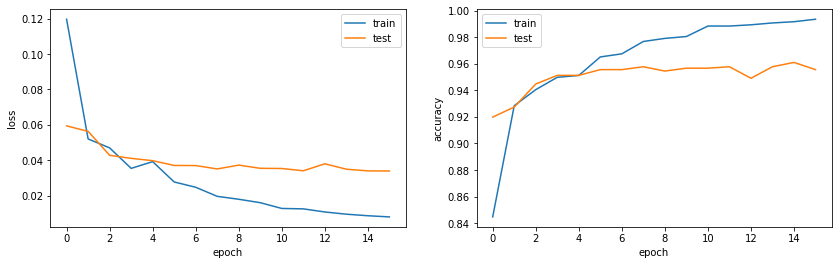

In [ ]:
show_results(history)

In [ ]:
images_sample = load_images('/drive/MyDrive/TACC/Reto/sample',sample_filenames)

In [ ]:
images_sample = rgb2gray(images_sample)
images_sample=np.asarray(images_sample)

images_sample = images_sample / 255.
mean = 0.5
std = 0.5
images_sample = (images_sample - mean) / std

images_sample = images_sample.reshape((-1, 128, 128, 1))

In [ ]:
predictions = model(images_sample)

In [ ]:
predictions=np.asarray(predictions)

In [ ]:
predictions = predictions.reshape(-1,)

In [ ]:
Resultados=pd.DataFrame(zip(sample_filenames,predictions),columns=['fileName','pneumonia'])

In [ ]:
Resultados

,fileName,pneumonia
0,b8f6db1b-8bc3-494f-84f0-f7ed6435e6d2.jpeg,0.999572
1,fb662f9a-b0c4-4ea6-b278-88161f17f4ad.jpeg,0.201786
2,97b254d1-c1a3-4554-9140-ec0203e355cf.jpeg,0.002888
3,01ae9376-8052-4cce-85bf-5019ebadaf32.jpeg,0.999331
4,c16175b7-218f-4e72-8e29-8c96c0f0df69.jpeg,0.998892
...,...,...
1020,9bc8bd30-d22f-4b97-ad19-09dc7cb5a65a.jpeg,0.790122
1021,afe25257-1533-49c0-bb38-61325a54de08.jpeg,0.998121
1022,5c3d905e-a282-4353-be3c-02515be35978.jpeg,0.999018
1023,cd476365-c360-4e8e-8292-5d9cdffa7e75.jpeg,0.019179


In [ ]:
Resultados.to_csv('/drive/MyDrive/TACC/Reto/caballos_submission.csv',index=False)